# Importing Libraries

In [138]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageChops, ImageEnhance
import glob
import random
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D,MaxPool2D, Dense, Flatten,Dropout
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Defining Constants

In [139]:
image_size=(128,128)
lr=1e-4
epochs = 10
batch_size = 32

# Showing Images

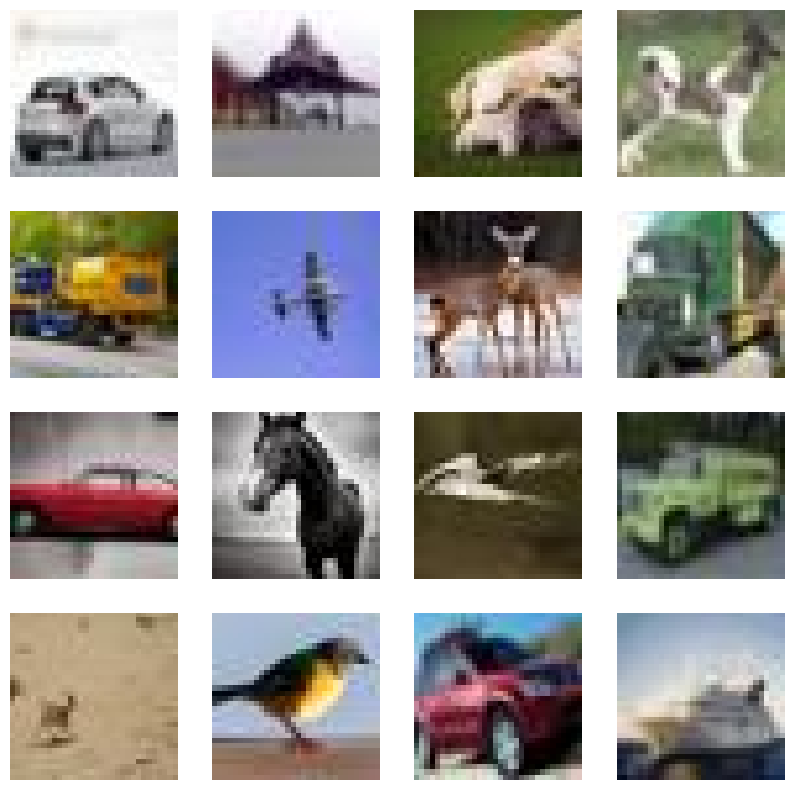

In [140]:
# folder="/kaggle/input/casia-dataset/"
# folder = "./cifake_subset/"
folder = "/home/ubuntu/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/"
paths=glob.glob(folder+"*/*/*.jpg")
_, axes = plt.subplots(4, 4, figsize=(10, 10))
random.shuffle(paths)
for ax, img_path in zip(axes.flatten(), paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

# Converting images to ela format for better accuracy

In [141]:
def convert_to_ela_image(image_path, quality=90):
    # Save the image at the given quality
    temp_file = 'temp.jpg'
    im = Image.open(image_path).convert('RGB')
    im.save(temp_file, 'JPEG', quality=100)

    # Open the saved image and the original image
    saved = Image.open(temp_file).convert('RGB')
    original = Image.open(image_path).convert('RGB')

    # Find the absolute difference between the images
    diff = ImageChops.difference(original, saved)

    # Normalize the difference by multiplying with a scale factor and convert to grayscale
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    # diff = ImageEnhance.Brightness(diff).enhance(scale)
    diff = ImageEnhance.Brightness(diff)
    if (max_diff != 0):
        scale = 255.0 / max_diff
        diff = diff.enhance(scale)
    else: diff = diff.enhance(1)

    # Remove the temporary file
    os.remove(temp_file)

    return diff

In [142]:
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path).resize(image_size)).flatten() / 255.0

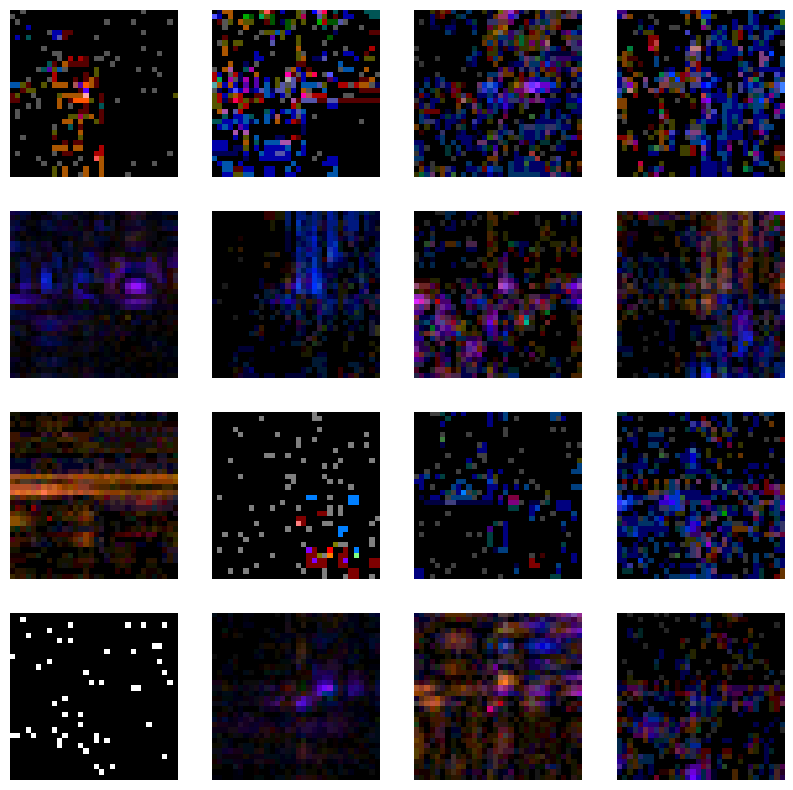

In [143]:
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), paths):
    ax.imshow(convert_to_ela_image(img_path))
    ax.axis("off")

# Creating train and validation data array

In [144]:
X=[]    #Stores images
Y=[]    #Stores classification 1 for real, 0 for fake
X_test = []
Y_test = []
# temp=[] #For data augmentation

In [146]:
# folder = '/kaggle/input/casia-dataset/CASIA2/Au/'
# folder = './cifake_subset/train/REAL/'
def load_images(folder, X, Y, size):
    paths=glob.glob(folder+"REAL/*.jpg")
    paths.append(glob.glob(folder+"REAL/*.png"))
    random.shuffle(paths)
    paths = paths[0:size]
    
    paths_y = []
    for i in paths: 
        paths_y.append((i, 1))
    paths = glob.glob(folder + "FAKE/*.jpg")
    paths.append(glob.glob(folder+"FAKE/*.png"))
    random.shuffle(paths)
    paths = paths[0:size]
    for i in paths: 
        paths_y.append((i, 0))
    
    random.shuffle(paths_y)

    for path, y in paths_y:
        if (type(path) == list): continue
        X.append(prepare_image(path))
        Y.append(y)
        if (len(Y) % 500 == 0): print("Processed %s images" % len(Y))

folder = "/home/ubuntu/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/%s/"
X_test = []
X = []
Y = []
Y_test = []
load_images(folder % "train", X, Y, 2000)
load_images(folder % "test", X_test, Y_test, 2000)

X_new = []
Y_new = []
folder2 = "/home/ubuntu/.cache/kagglehub/datasets/saurabhbagchi/deepfake-image-detection/versions/2/%s/"
load_images(folder2 % "train-20250112T065955Z-001/train", X_new, Y_new, 2000)
load_images(folder2 % "test-20250112T065939Z-001/test", X_new, Y_new, 2000)

Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images
Processed 500 images
Processed 1000 images
Processed 1500 images
Processed 2000 images
Processed 2500 images
Processed 3000 images
Processed 3500 images
Processed 4000 images


In [88]:
# folder = '/kaggle/input/casia-dataset/CASIA2/Tp/'
# folder = './cifake_subset/train/FAKE/'
# folder = "/home/ubuntu/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train/FAKE/"
# paths=glob.glob(folder+"*.jpg")
# paths.append(glob.glob(folder+"*.png"))
# # paths=paths[0:2000]
# paths = paths[0:7000]
# random.shuffle(paths)
# paths = paths[0:2000]
# for path in paths:
#     if (type(path) == list): continue
#     temp.append(prepare_image(path))

# Data Augmentation

In [10]:
datagen = ImageDataGenerator(height_shift_range=0.3,width_shift_range=0.3,horizontal_flip=True)

samples = temp[0].reshape(1,128, 128, 3)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

NameError: name 'temp' is not defined

In [11]:
datagen = ImageDataGenerator(height_shift_range=0.3,width_shift_range=0.3,horizontal_flip=True)
for cnt,img in enumerate(temp):
    samples = img.reshape(1,128, 128, 3)
    it = datagen.flow(samples, batch_size=1)
    for i in range(3):
        batch = it.next()
        image = batch[0]
        X.append(image.flatten())
        Y.append(0)
    if (cnt+1)%250==0: print(f'Processing {cnt+1} images')

NameError: name 'temp' is not defined

In [93]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

X_test = np.array(X_test)
Y_test = to_categorical(Y_test, 2)
X_test = X_test.reshape(-1, 128, 128, 3)
X_test = X_test.reshape(-1, 1, 1, 1)

In [94]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)
print(f'No of elements in train dataset {len(X_train)}')
print(f'No of elements in validation dataset {len(X_val)}')
print(f'Total no of elements {len(X)}')
X = X.reshape(-1,1,1,1)

No of elements in train dataset 3200
No of elements in validation dataset 800
Total no of elements 4000


# Creating a model

In [147]:
def define_model():
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(Conv2D(filters = 32, kernel_size = (5, 5), padding = 'valid', activation = 'relu', input_shape = (128, 128, 3)))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation = 'softmax'))
    optimizer = Adam(learning_rate = lr, decay = lr/epochs)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [148]:
model = define_model()
model.summary()

/home/ubuntu/project/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/ubuntu/project/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 124, 124, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 120, 120, 32)   │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 60, 60, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,520,034 (112.61 MB)

 Trainable params: 29,520,034 (112.61 MB)

 Non-trainable params: 0 (0.00 B)

# Create functions to plot statistics

In [171]:
def summarize_diagnostics(history):
    fig,ax=plt.subplots(2)
    fig.suptitle("Loss")
    fig.tight_layout()
    # plot loss
    ax[0].set_title('Cross Entropy Loss')
    ax[0].plot(history.history['loss'], color='blue', label='Training loss')
    ax[0].plot(history.history['val_loss'], color='orange', label='validation loss')
    ax[0].legend(loc='best', shadow=True)
    # plot accuracy
    ax[1].set_title('Classification Accuracy')
    ax[1].plot(history.history['accuracy'], color='blue', label='train')
    ax[1].plot(history.history['val_accuracy'], color='orange', label='test')
    ax[1].legend(loc='best', shadow=True)
    
def print_confusion_metric(y_true, y_preds):
    cm = confusion_matrix(y_true, y_preds, normalize='all')
    cmd = ConfusionMatrixDisplay(cm, display_labels=['AI Image','Real Image'])
    cmd.plot()

# Training the data

In [172]:
early_stopping = EarlyStopping(monitor = 'val_acc',
                              min_delta = 0,
                              patience = 2,
                              verbose = 0,
                              mode = 'max')

hist = model.fit(X_train,
                 Y_train,
                 batch_size = batch_size,
                 epochs = epochs,
                validation_data = (X_val, Y_val),
                callbacks = [early_stopping],
                )

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9302 - loss: 0.2136 - val_accuracy: 0.6712 - val_loss: 0.8518
Epoch 2/10
  5/100 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9252 - loss: 0.2130

/home/ubuntu/project/venv/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss
  current = self.get_monitor_value(logs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9493 - loss: 0.1700 - val_accuracy: 0.6562 - val_loss: 0.8461
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9578 - loss: 0.1450 - val_accuracy: 0.6513 - val_loss: 0.8818
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9762 - loss: 0.1150 - val_accuracy: 0.6725 - val_loss: 0.9444
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9819 - loss: 0.0884 - val_accuracy: 0.6550 - val_loss: 1.1491
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9751 - loss: 0.0945 - val_accuracy: 0.6488 - val_loss: 1.0623
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9895 - loss: 0.0630 - val_accuracy: 0.6637 - val_loss: 1.1238
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9917 - loss: 0.0536 - val_accuracy: 0.6650 - val_loss: 1.2215
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9962 - loss: 0.0429 - val_accuracy: 0.656

In [173]:
model.save('model_casia_AI_image_predictor_cnn.h5')

In [174]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [175]:
print(f'Training Loss: {hist.history["loss"][-1]}')
print(f'Validation Loss: {hist.history["val_loss"][-1]}')
print(f'Training Accuracy: {hist.history["accuracy"][-1]}')
print(f'Validation Accuracy: {hist.history["val_accuracy"][-1]}')
print(f'No of correct validation images: {np.sum(Y_true==Y_pred_classes)}')
print(f'No of incorrect validation images: {np.sum(Y_true!=Y_pred_classes)}')

Training Loss: 0.03607434406876564
Validation Loss: 1.2509117126464844
Training Accuracy: 0.9950000047683716
Validation Accuracy: 0.6575000286102295
No of correct validation images: 526
No of incorrect validation images: 274


Graphs:


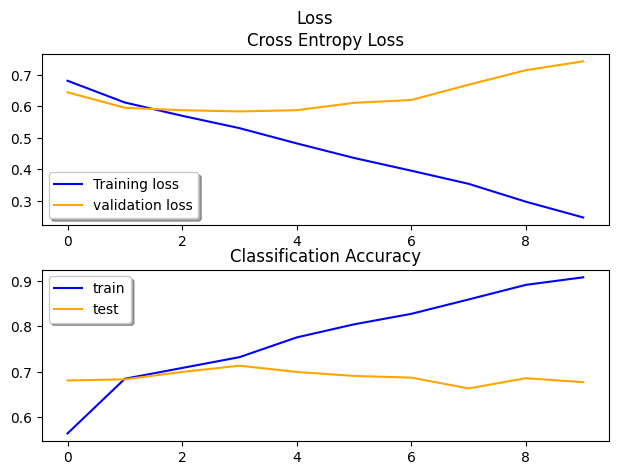

In [153]:
print("Graphs:")
summarize_diagnostics(hist)

Validation dataset confusion metrics:


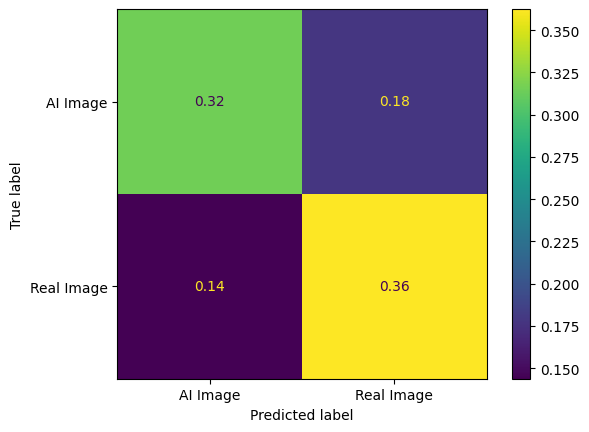

In [154]:
print("Validation dataset confusion metrics:")
print_confusion_metric(Y_true,Y_pred_classes)

In [155]:
class_names = ['Fake Image', 'Real Image']
folder="/kaggle/input/casia-dataset/"
paths=glob.glob(folder+"*/*/*.jpg")
paths.append(glob.glob(folder+"*.png"))

In [127]:
path=random.choice(paths)

plt.imshow(Image.open(path))
plt.axis('off')
image = prepare_image(path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
y_true="Real Image" if ('Au' in path) else "Fake Image"

print("\n\n")
print(f'File Name: {path}')
print(f'Confidence: {np.amax(y_pred) * 100:0.2f}')
print(f'Predicted Class: {class_names[y_pred_class]}')
print(f'Actual Class: {y_true}')

AttributeError: 'list' object has no attribute 'read'

In [156]:
X_new = np.array(X_new)
X_new = X_new.reshape(-1, 128, 128, 3)

In [157]:
Y_new = to_categorical(Y_new, 2)

In [176]:
Y_pred_new = model.predict(X_new)
Y_pred_classes_new = np.argmax(Y_pred_new, axis=1)
Y_true_new = np.argmax(Y_new, axis=1)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


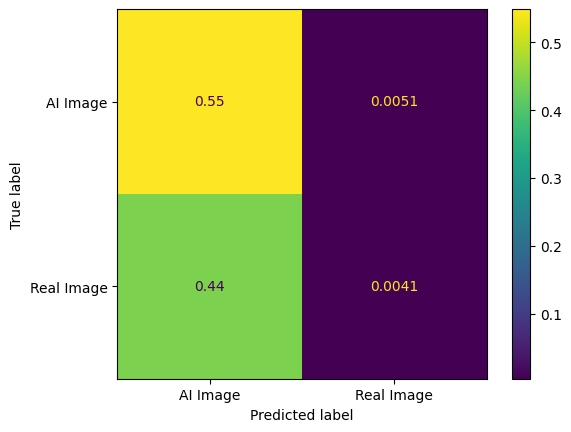

In [177]:
print_confusion_metric(Y_true_new,Y_pred_classes_new)

In [178]:
print(np.average(Y_pred_classes_new))

0.009202453987730062


In [179]:
num_correct = np.sum(Y_pred_classes_new == Y_true_new)
print("Accuracy = %s" % (num_correct / len(Y_pred_classes_new)))

Accuracy = 0.5531697341513292
